In [1]:
import code_tokenize
import re
def my_tokenizer(text):
    text = re.sub(r'\b\d+\.\d+\b', lambda x: str(float(x.group())), text)
    tokens = code_tokenize.tokenize(text, lang="c", syntax_error="ignore")
    tokens_list = [str(x) for x in tokens]
    return tokens_list

In [2]:
# tokenize the data that can be used by embeddings
from tensorflow.keras.preprocessing.text import Tokenizer
import os
import pickle


tokenizer_path = "F://Development_//Deep Learning//Basic Dataset//BTP//1//Dataset//tokenizer.pkl"
retrain = False
if os.path.exists(tokenizer_path) and not retrain:
    print("[INFO] Loading saved tokenizer")
    with open(tokenizer_path, "rb") as tokenizer_file:
        tokenizer = pickle.load(tokenizer_file)
else:
    t0 = time()
    print("[INFO] fitting tokenizer on TRAIN data...")
    tokenizer = Tokenizer(lower=False, analyzer = my_tokenizer)  # used in the research paper
    tokenizer.fit_on_texts(X_train.apply(lambda x: np.str_(x)))
    # save the tokenizer for future use
    with open(tokenizer_path, "wb") as tokenizer_file:
        pickle.dump(tokenizer, tokenizer_file, protocol=pickle.HIGHEST_PROTOCOL)
        # pickle.HIGHEST_PROTOCOL is highest protocol version available
    print(f"time taken to fit and save the tokenizer: {time()-t0} s")   

[INFO] Loading saved tokenizer


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs
1
2


C:\Users\shaur\miniconda3\envs\tf\lib\site-packages\tree_sitter\__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


3
4
5
6
DEBUG:tensorflow:RNN `implementation=2` is not supported when `recurrent_dropout` is set. Using `implementation=1`.


DEBUG:tensorflow:RNN `implementation=2` is not supported when `recurrent_dropout` is set. Using `implementation=1`.


Epoch 1/10
3011/3011 [==============================] - 2498s 830ms/step - loss: 0.4035 - accuracy: 0.8456 - val_loss: 0.3771 - val_accuracy: 0.8512
Epoch 2/10
3011/3011 [==============================] - 2440s 810ms/step - loss: 0.3710 - accuracy: 0.8550 - val_loss: 0.3599 - val_accuracy: 0.8600
Epoch 3/10
3011/3011 [==============================] - 2449s 814ms/step - loss: 0.3581 - accuracy: 0.8602 - val_loss: 0.3541 - val_accuracy: 0.8636
Epoch 4/10
3011/3011 [==============================] - 2443s 811ms/step - loss: 0.3495 - accuracy: 0.8634 - val_loss: 0.3510 - val_accuracy: 0.8662
Epoch 5/10
3011/3011 [==============================] - 2452s 814ms/step - loss: 0.3428 - accuracy: 0.8657 - val_loss: 0.3457 - val_accuracy: 0.8666
Epoch 6/10
3011/3011 [==============================] - 2440s 810ms/step - loss: 0.3381 - accuracy: 0.8676 - val_loss: 0.3470 - val_accuracy: 0.8692
Epoch 7/10
3011/3011 [==============================] - 2482s 824ms/step - loss: 0.3344 - accuracy: 0.8688

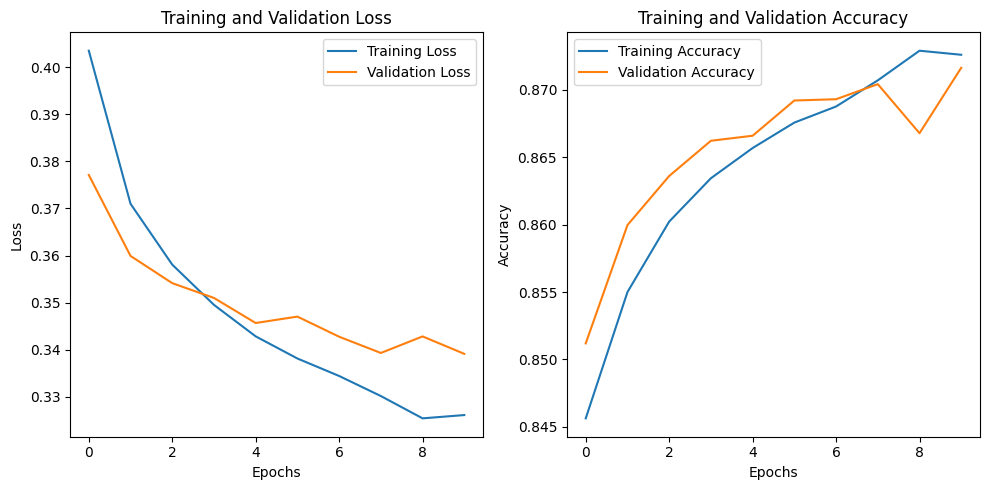

372/372 [==============================] - 128s 344ms/step
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     10000
           1       0.80      0.28      0.41      1895

    accuracy                           0.87     11895
   macro avg       0.84      0.63      0.67     11895
weighted avg       0.87      0.87      0.85     11895

Confusion Matrix:
[[9869  131]
 [1369  526]]


In [3]:
import os
import pandas as pd
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.utils import to_categorical


os.environ['TF_FORCE_UNIFIED_MEMORY']='1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='2.0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH ']='true' # as I understood, this is redundant with the set_memory_growth part :)

import tensorflow as tf    
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print(gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel(tf.compat.v1.logging.DEBUG)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam

import pickle
from gensim.models import Word2Vec

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


def tokenize_sequences(X_train, X_test, X_val, tokenizer):
    X_train = [str(code) for code in X_train]  # Convert any non-string elements to string
    X_train = tokenizer.texts_to_sequences(X_train)

    X_val = [str(code) for code in X_val]  # Convert any non-string elements to string
    X_val = tokenizer.texts_to_sequences(X_val)

    X_test = [str(code) for code in X_test]  # Convert any non-string elements to string
    X_test = tokenizer.texts_to_sequences(X_test)

    max_length_train = max(len(sequence) for sequence in X_train)
    max_length_val = max(len(sequence) for sequence in X_val)
    max_length_test = max(len(sequence) for sequence in X_test)

    maxlen = 100

    X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
    X_val = pad_sequences(X_val, padding="post", maxlen=maxlen)
    X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

    return X_train, X_val, X_test

def load_data():
    df= pd.read_csv('F://Development_//Deep Learning//Basic Dataset//BTP//1//Dataset//CSVs//preprocessed_df_100k.csv')
    X_train, X_test, y_train, y_test = train_test_split(
        df.func,
        df.target,
        test_size=0.1,
        random_state=42,
        stratify=df.target,
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.1,
        random_state=42,
        stratify=y_train,
    )

    return X_train, X_val, X_test, y_train, y_val, y_test





def load_embedding_model(x):
  filename = f'F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Embedding Models 3//Word2vec//word2vec_{x}_model.pkl'

  with open(filename, 'rb') as f:
    embedding_model = pickle.load(f)

  return embedding_model


def create_model(vocab_size, embedding_dim, embedding_matrix, max_sequence_length):
    # Create an Adam optimizer with the desired learning rate
    adam_optimizer = Adam(learning_rate=0.001)

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False, name='GRU_W2V_EL'))
    # Add GRU layer with dropout
    model.add(GRU(units=100, name='GRU_W2V', dropout=0.2, recurrent_dropout=0))  
    # Add Dense layer with regularization
    model.add(Dense(units=2, activation='softmax', name='GRU_W2V_OL', kernel_regularizer=l2(0.01)))  

    # Compile the model with the custom optimizer
    model.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

    return model




def evaluate_model(X_test_padded, y_test, model):
    y_pred_prob = model.predict(X_test_padded)  

    y_pred = np.argmax(y_pred_prob, axis=1)

    if y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    report = classification_report(y_test, y_pred)
    print(report)

    confusion = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(confusion)


def predict_additional_data(test_padded, model):
    test_pred_prob = model.predict(test_padded)
    test_pred = (test_pred_prob > 0.5).astype(int)
    return test_pred


def save_model(model, fold):
    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Checkpoints//Sentence//LSTM//Word2vec//model10k_fold_{fold}.h5")




print("1")
# Tokenize the sequences
X_train, X_val, X_test, y_train, y_val, y_test = load_data()
print("2")

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)



X_train_padded, X_val_padded, test_padded = tokenize_sequences(X_train, X_test, X_val, tokenizer)
print("3")


embedding_dims = [50]

for embedding_dim in embedding_dims:
    print("4")

    embedding_model = load_embedding_model(embedding_dim)
    print("5")

    
    # Create the embedding matrix
    embedding_dim = embedding_dim
    vocab_size = 559321
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size and word in embedding_model.wv:
            embedding_matrix[i] = embedding_model.wv[word]
    print("6")
    # Create a sequential model
    model = create_model(vocab_size, embedding_dim, embedding_matrix, X_train_padded.shape[1])
          
    
    history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_val_padded, y_val))
    
    # Plot both loss and accuracy
    plt.figure(figsize=(10, 5))  # Adjust figure size as desired
    plt.subplot(1, 2, 1)  # Create subplot for loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
        
    plt.subplot(1, 2, 2)  # Create subplot for accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()
    # Evaluate the model using the test set
    evaluate_model(test_padded, y_test, model)
    
    # Predict on the additional test set
    # test_pred = predict_additional_data(test_padded, model)        
        
    model.save(f"F://Development_//Deep Learning//Basic Dataset//BTP//1//Outputs//Models//LSTM//word2vec 2/GRU_w2v_{embedding_dim}.keras")
    